# Updated Cooling Center Notebook
March 13, 2025

This notebook contains 
1. In-depth descriptive statistics of formal cooling centers in LA County 
2. Cooling Center index code 
3. Local and Global Spatial Autocorrelation 

(From late feb)The purpose of this assignment is to conduct spatial autocorrelation to find out if cooling center locations have a statistical significant tendency to cluster in certain census tracts in LA County. Our approach is:

- import census tracts boundaries for Los Angeles
- import cooling center data from the LA Ready (building off of previous code on cooling centers for our final project) 
- spatially join the two datasets

(Jump to the bottom of the notebook for Spatial Autocorrelation)

- normalize the data to create cooling centers per 4,000(avg. number of people in census tracts in LA) 
- conduct global spatial autocorrelation using Moran's I
- conduct local spatial autocorrelation using Local Indicators of Spatial Association (LISAs)

In [1]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics`
import plotly.express as px
import matplotlib.pyplot as plt

#for distance calculations 
from shapely.geometry import Point
import numpy as np

### Read into our first csv file containing information on LA County Cooling Centers, downloaded from [ReadyLA.gov](https://ready.lacounty.gov/heat/) 
- clean dataframe
- convert into a geopandas dataframe using the provided latitude and longitude points


In [2]:
#read into Cooling Center data downloaded from LA Ready 
centers = pd.read_csv("data/GeocodeResultsCleaned_CoolingCenters(Sheet0).csv", encoding='windows-1254')

In [3]:
centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   RECORD ID NUMBER                     190 non-null    object 
 1   INPUT ADDRESS                        190 non-null    object 
 2   TIGER ADDRESS RANGE MATCH INDICATOR  190 non-null    object 
 3   TIGER MATCH TYPE                     175 non-null    object 
 4   TIGER OUTPUT ADDRESS                 190 non-null    object 
 5   LONGITUDE                            190 non-null    float64
 6   LATITUDE                             190 non-null    float64
 7   TIGERLINE ID                         175 non-null    float64
 8   TIGERLINE ID SIDE                    175 non-null    object 
 9   STATE CODE                           190 non-null    int64  
 10  COUNTY CODE                          190 non-null    int64  
 11  TRACT CODE                      

In [4]:
#identify column names
centers.columns

Index(['RECORD ID NUMBER', 'INPUT ADDRESS ',
       'TIGER ADDRESS RANGE MATCH INDICATOR', 'TIGER MATCH TYPE',
       'TIGER OUTPUT ADDRESS', 'LONGITUDE ', 'LATITUDE', 'TIGERLINE ID',
       'TIGERLINE ID SIDE', 'STATE CODE', 'COUNTY CODE', 'TRACT CODE',
       'BLOCK CODE'],
      dtype='object')

In [5]:
#rename the longitude column, which has a following space attached to its name from the original download
centers = centers.rename(columns={'LONGITUDE ': 'LONGITUDE', 'INPUT ADDRESS ': 'Address', 'RECORD ID NUMBER' : 'Name'})

In [6]:
#convert column names to lowercase 
centers.columns = centers.columns.str.lower()
centers.columns

Index(['name', 'address', 'tiger address range match indicator',
       'tiger match type', 'tiger output address', 'longitude', 'latitude',
       'tigerline id', 'tigerline id side', 'state code', 'county code',
       'tract code', 'block code'],
      dtype='object')

In [7]:
#convert state, tract and county code columns to string in order to create a FIPs code
centers[['state code', 'tract code', 'county code']] = centers[['state code', 'tract code', 'county code']].astype(str)

We want to understand where centers are concentrated. First, we need to extract the city string from the address string.

In [8]:
#split address by street, city, zip to extract city to understand which cities have higher concentrations of centers
centers[['street', 'city', 'zip']] = centers["address"].str.split(",", n=2, expand=True)
centers['city']

0             Sylmar
1       Porter Ranch
2            Burbank
3            Compton
4       Los Angeles 
           ...      
185      Los Angeles
186       Montebello
187             Bell
188     La Crescenta
189         Van Nuys
Name: city, Length: 190, dtype: object

In [9]:
#strip by trailing characters on the right side of the string
centers['city'] = centers['city'].str.rstrip()

In [10]:
centers.columns

Index(['name', 'address', 'tiger address range match indicator',
       'tiger match type', 'tiger output address', 'longitude', 'latitude',
       'tigerline id', 'tigerline id side', 'state code', 'county code',
       'tract code', 'block code', 'street', 'city', 'zip'],
      dtype='object')

In [11]:
# Indices of columns to drop
# we do not need tigerline information
column_indices_to_drop = [2,3,4,7,8,9,10]

# Drop columns by index
centers = centers.drop(centers.columns[column_indices_to_drop], axis=1)

In [12]:
#check centers df
centers.head()

,name,address,longitude,latitude,tract code,block code,street,city,zip
0,Veteran's Memorial Community Regional Park,"13000 Sayre St, Sylmar, 91342",-118.417156,34.324843,106111,2003,13000 Sayre St,Sylmar,91342
1,Porter Ranch Branch Library,"11371 Tampa Avenue, Porter Ranch, 91326",-118.558526,34.276780,108102,1000,11371 Tampa Avenue,Porter Ranch,91326
2,Northwest Library,"3323 W. Victory Blvd., Burbank, 91505",-118.347214,34.184764,311000,3017,3323 W. Victory Blvd.,Burbank,91505
3,Roy Campanella Park,"14812 S Stanford Ave, Compton, 90220",-118.261095,33.898681,541100,3001,14812 S Stanford Ave,Compton,90220
4,A C Bilbrew Library,"150 E El Segundo Blvd , Los Angeles , 90061",-118.272094,33.916366,540902,3002,150 E El Segundo Blvd,Los Angeles,90061


In [13]:
#create a geometry column to create a single geographic location point using the provided longitude and latitude points
centers['geometry'] = gpd.points_from_xy(centers.longitude, centers.latitude)

In [14]:
#convert centers into a geopandas 
centers = gpd.GeoDataFrame(centers, 
                           crs='epsg: 4326', #second parameter is the crs code
                           geometry=centers['geometry']) #thrid parameter is geometry which needs to know which long/lat points to map to
centers.head()

,name,address,longitude,latitude,tract code,block code,street,city,zip,geometry
0,Veteran's Memorial Community Regional Park,"13000 Sayre St, Sylmar, 91342",-118.417156,34.324843,106111,2003,13000 Sayre St,Sylmar,91342,POINT (-118.41716 34.32484)
1,Porter Ranch Branch Library,"11371 Tampa Avenue, Porter Ranch, 91326",-118.558526,34.276780,108102,1000,11371 Tampa Avenue,Porter Ranch,91326,POINT (-118.55853 34.27678)
2,Northwest Library,"3323 W. Victory Blvd., Burbank, 91505",-118.347214,34.184764,311000,3017,3323 W. Victory Blvd.,Burbank,91505,POINT (-118.34721 34.18476)
3,Roy Campanella Park,"14812 S Stanford Ave, Compton, 90220",-118.261095,33.898681,541100,3001,14812 S Stanford Ave,Compton,90220,POINT (-118.2611 33.89868)
4,A C Bilbrew Library,"150 E El Segundo Blvd , Los Angeles , 90061",-118.272094,33.916366,540902,3002,150 E El Segundo Blvd,Los Angeles,90061,POINT (-118.27209 33.91637)


In [15]:
#check that the df is now a geopandas df 
type(centers)

geopandas.geodataframe.GeoDataFrame

### Explore spatial distribution of centers 
- find average distance between centers

In [16]:
#find distance between centers by importing numpy 
def avg_dist(gdf):
    # List of points (replace with your full dataset)
    coords = [(point.x, point.y) for point in gdf.geometry]

    # Reproject to a suitable CRS (EPSG:2229 for LA County in feet, EPSG:26945 for meters)
    gdf = gdf.to_crs(epsg=2229)  # Use 26945 if you prefer meters
    
    # Compute pairwise distance matrix
    dist_matrix = gdf.geometry.apply(lambda g: gdf.distance(g))
    
    # Extract upper triangle (excluding diagonal)
    distances = dist_matrix.to_numpy()
    upper_triangle = distances[np.triu_indices(len(gdf), k=1)]
    
    # Compute average distance
    average_distance_feet = round(upper_triangle.mean(), 2)
    average_distance_miles = round((average_distance_feet / 5280), 2)
    return average_distance_miles

In [17]:
avg_dist_LA_County = avg_dist(centers)
print("The average distance between centers in LA county is " + str(avg_dist_LA_County) + " miles.")

The average distance between centers in LA county is 20.3 miles.


In [18]:
#look specifically at centers in the city of LA 
LA_centers = centers[centers['city'] == ' Los Angeles']

In [19]:
LA_centers

,name,address,longitude,latitude,tract code,block code,street,city,zip,geometry
4,A C Bilbrew Library,"150 E El Segundo Blvd , Los Angeles , 90061",-118.272094,33.916366,540902,3002,150 E El Segundo Blvd,Los Angeles,90061,POINT (-118.27209 33.91637)
5,Col. Leon H. Washington Park,"8908 Maie Ave, Los Angeles, 90002",-118.244150,33.953341,535200,1000,8908 Maie Ave,Los Angeles,90002,POINT (-118.24415 33.95334)
10,John Muir Branch Library,"1005 W. 64th Street, Los Angeles, 90044",-118.292070,33.981487,237401,2001,1005 W. 64th Street,Los Angeles,90044,POINT (-118.29207 33.98149)
11,East Los Angeles Service Center,"133 N. Sunol Drive, Los Angeles, 90063",-118.178697,34.036756,531102,1006,133 N. Sunol Drive,Los Angeles,90063,POINT (-118.1787 34.03676)
13,Robertson Branch Library,"1719 S. Robertson Boulevard, Los Angeles, 90035",-118.385683,34.048454,217001,1013,1719 S. Robertson Boulevard,Los Angeles,90035,POINT (-118.38568 34.04845)
...,...,...,...,...,...,...,...,...,...,...
169,Malabar Branch Library,"2801 Wabash Avenue, Los Angeles, 90033",-118.197889,34.050512,203200,1005,2801 Wabash Avenue,Los Angeles,90033,POINT (-118.19789 34.05051)
170,Pico Union Branch Library,"1030 S. Alvarado Street, Los Angeles, 90006",-118.280076,34.051233,209520,2003,1030 S. Alvarado Street,Los Angeles,90006,POINT (-118.28008 34.05123)
177,East L.A./West San Gabriel Valley Comprehensiv...,"5301 Whittier Blvd. 2nd Floor, Los Angeles, 90022",-118.155715,34.020561,531701,2008,5301 Whittier Blvd. 2nd Floor,Los Angeles,90022,POINT (-118.15572 34.02056)
178,Jefferson - Vassie D. Wright Memorial Branch ...,"2211 W. Jefferson Boulevard, Los Angeles, 90018",-118.319209,34.026104,219010,1009,2211 W. Jefferson Boulevard,Los Angeles,90018,POINT (-118.31921 34.0261)


In [20]:
avg_dist_LA_City = avg_dist(LA_centers)
print("The average distance between centers in the city of LA is " + str(avg_dist_LA_City) + " miles.")

The average distance between centers in the city of LA is 7.49 miles.


In [21]:
# count the number of centers per tract
centers_by_tract = centers.value_counts(centers['tract code']).reset_index(name='centers_count').sort_values(by='centers_count', ascending=False)
centers_by_tract.rename(columns={'tract_code': 'Tract'})
   # merged_df = df1.merge(df2, on="tract_id", how="left")

,tract code,centers_count
0,104124,2
1,106111,2
2,228710,2
3,535200,2
4,540902,2
...,...,...
174,911001,1
175,911100,1
176,920048,1
177,920106,1


In [22]:
tract_morethan1 = centers_by_tract[centers_by_tract['centers_count'] >= 2]
print("There are " + str(len(tract_morethan1)) + " census tracts with 2 or more centers.")

There are 11 census tracts with 2 or more centers.


In [23]:
tract_just1 = centers_by_tract[centers_by_tract['centers_count'] == 1]
print("There are " + str(len(tract_just1)) + " census tracts with only 1 center.")

There are 168 census tracts with only 1 center.


In [24]:
#count the number of centers per CITY 
centers_by_city = centers.value_counts('city').reset_index(name='count').sort_values(by='count', ascending=False)
city_morethan1 = centers_by_city[centers_by_city['count'] >= 2]
city_morethan1

,city,count
0,Los Angeles,64
1,Inglewood,6
2,Torrance,6
3,Sylmar,4
4,Compton,4
5,Whittier,4
6,Lancaster,3
7,Pomona,3
8,Altadena,3
9,Hacienda Heights,2


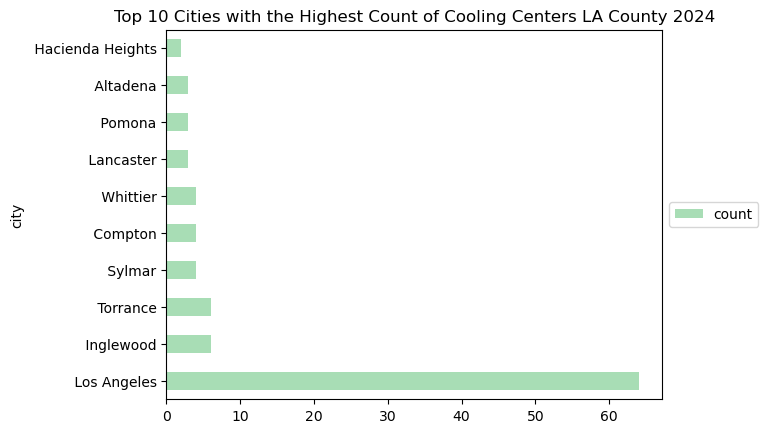

In [25]:
ax = city_morethan1.head(10).plot.barh(x='city',
                                   y='count',
                                   title= 'Top 10 Cities with the Highest Count of Cooling Centers LA County 2024',
                                   color = '#a8ddb5')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.figure.savefig('top_10_cities_centers.png', bbox_inches='tight')

Based on the analysis, we see that the average straight line distance between centers in the City of LA is 7.49 miles, while the average straightline distance between centers across the county is 20.3 miles. 

Because we want to understand general trends about centers in LA County, we chose to look at count per city in addition to count per census tracts, as this provides more information to an average citizen. According to the data, Los Angeles has the highest count of centers, followed by Inglewood and Torrance. 

Next, we will move onto mapping the centers to visualize where centers are distributed and concentrated. 

### Read into our second dataset census tracts in LA County and clean.

In [26]:
#read into the geojson file downloaded from the US Census Reporter  
tracts = gpd.read_file("data/acs2023_5yr_B01003_14000US06037575001.geojson")

In [27]:
tracts.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             2498 non-null   object  
 1   name              2498 non-null   object  
 2   B01003001         2498 non-null   float64 
 3   B01003001, Error  2498 non-null   float64 
 4   geometry          2498 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 97.7+ KB


In [28]:
tracts.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             2498 non-null   object  
 1   name              2498 non-null   object  
 2   B01003001         2498 non-null   float64 
 3   B01003001, Error  2498 non-null   float64 
 4   geometry          2498 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 97.7+ KB


In [29]:
# trim the data to the bare minimum columns
tracts = tracts[['geoid','B01003001','geometry']]

# rename the columns
tracts.columns = ['FIPS','TotalPop','geometry']
tracts['tract code'] = tracts['FIPS'].str.replace('14000US06037','') #take away US, state, and county identifier to get census tract  
tracts['FIPS'] = tracts['FIPS'].str.replace('14000US','').astype(str) #replace 14,000 US with nothing since every row has this US identifier in FIPS

In [30]:
#drop tracts with less than 100 people 
tracts.drop(tracts.loc[tracts['TotalPop']<=100].index, inplace=True)
#drop Avalon and San Clemente Islands 
tracts.drop(tracts.loc[tracts['tract code']=='599000'].index, inplace=True)
tracts.drop(tracts.loc[tracts['tract code']=='600000'].index, inplace=True)
tracts.drop(tracts.loc[tracts['tract code']=='599100'].index, inplace=True)

In [31]:
tracts.shape

(2466, 4)

In [32]:
#add count from centers to tracts 
tracts = tracts.merge(centers_by_tract, on="tract code", how="left")

In [33]:
tracts

,FIPS,TotalPop,geometry,tract code,centers_count
0,06037101110,4152.0,"MULTIPOLYGON (((-118.30229 34.2587, -118.30091...",101110,1.0
1,06037101122,4198.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033...",101122,NaN
2,06037101220,3434.0,"MULTIPOLYGON (((-118.28592 34.25404, -118.2859...",101220,NaN
3,06037101221,3931.0,"MULTIPOLYGON (((-118.29792 34.25597, -118.2969...",101221,NaN
4,06037101222,2572.0,"MULTIPOLYGON (((-118.29434 34.25233, -118.2931...",101222,NaN
...,...,...,...,...,...
2461,06037980024,205.0,"MULTIPOLYGON (((-118.51849 34.18389, -118.5184...",980024,NaN
2462,06037980025,442.0,"MULTIPOLYGON (((-118.26461 33.84746, -118.2638...",980025,NaN
2463,06037980031,970.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905...",980031,NaN
2464,06037980035,642.0,"MULTIPOLYGON (((-117.998 34.02967, -117.99643 ...",980035,NaN


### Plot tracts and cooling centers on a map 

In [34]:
tracts = tracts.to_crs(epsg=3857) #keep consistent projection 

(np.float64(-13248145.99104223),
 np.float64(-13089105.326227056),
 np.float64(3980592.6349664824),
 np.float64(4147480.1012758403))

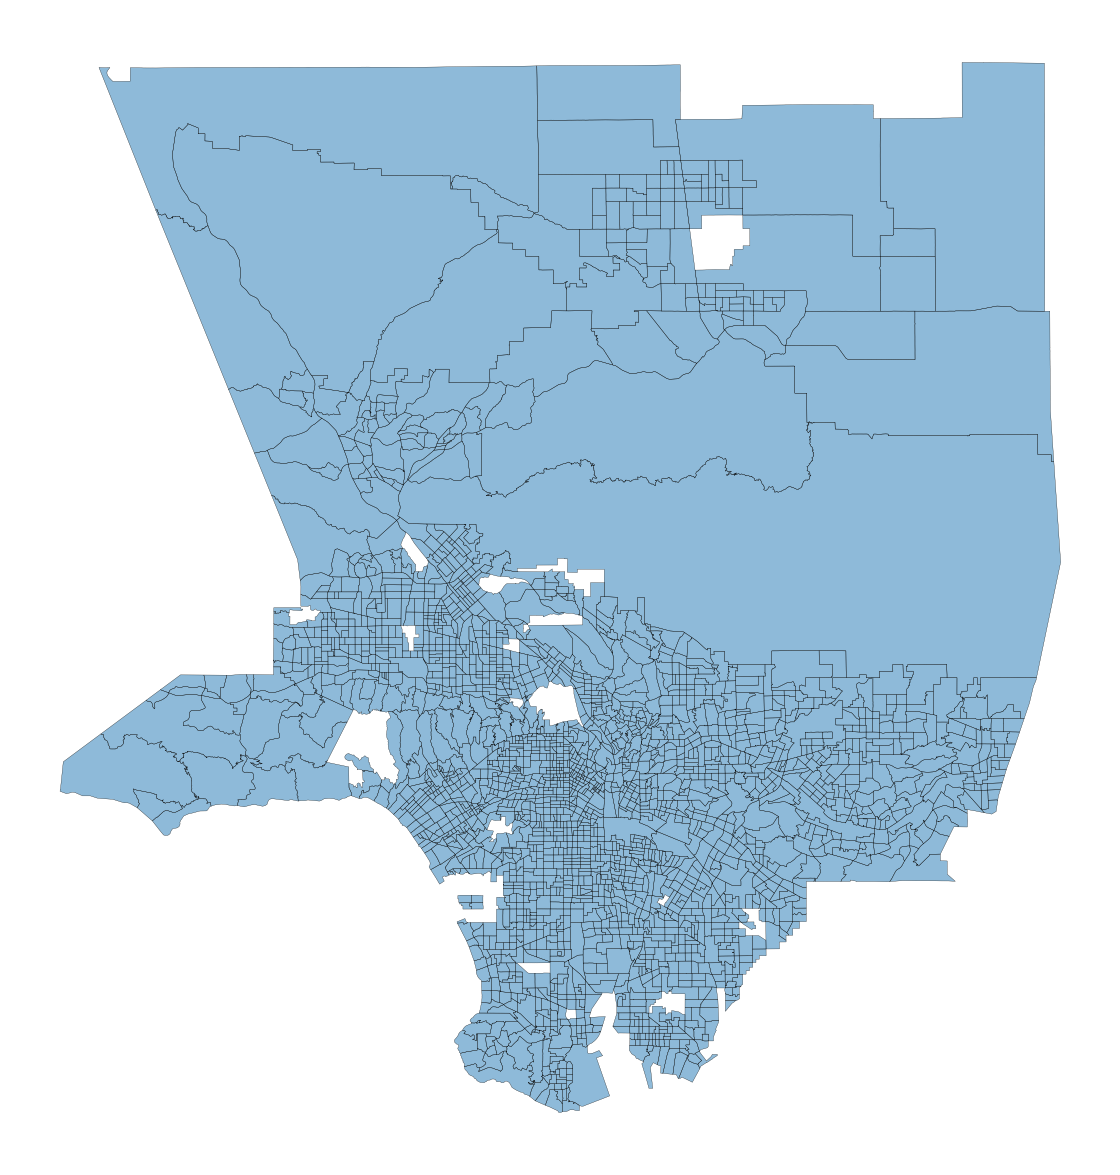

In [35]:
#plot tracts
fig,ax = plt.subplots(figsize=(15,15))
tracts.plot(ax=ax,zorder=10,alpha=0.5) #z is lowest layer on the plot, alpha is transparency
tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=0.2)

# axis
ax.axis('off')

In [36]:
centers = centers.to_crs(epsg=3857)

In [37]:
# get the bounding box coordinates for the centers data
minx, miny, maxx, maxy = centers.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13224683.415738665
-13104123.360806333
3993459.184591898
4123719.9021027423


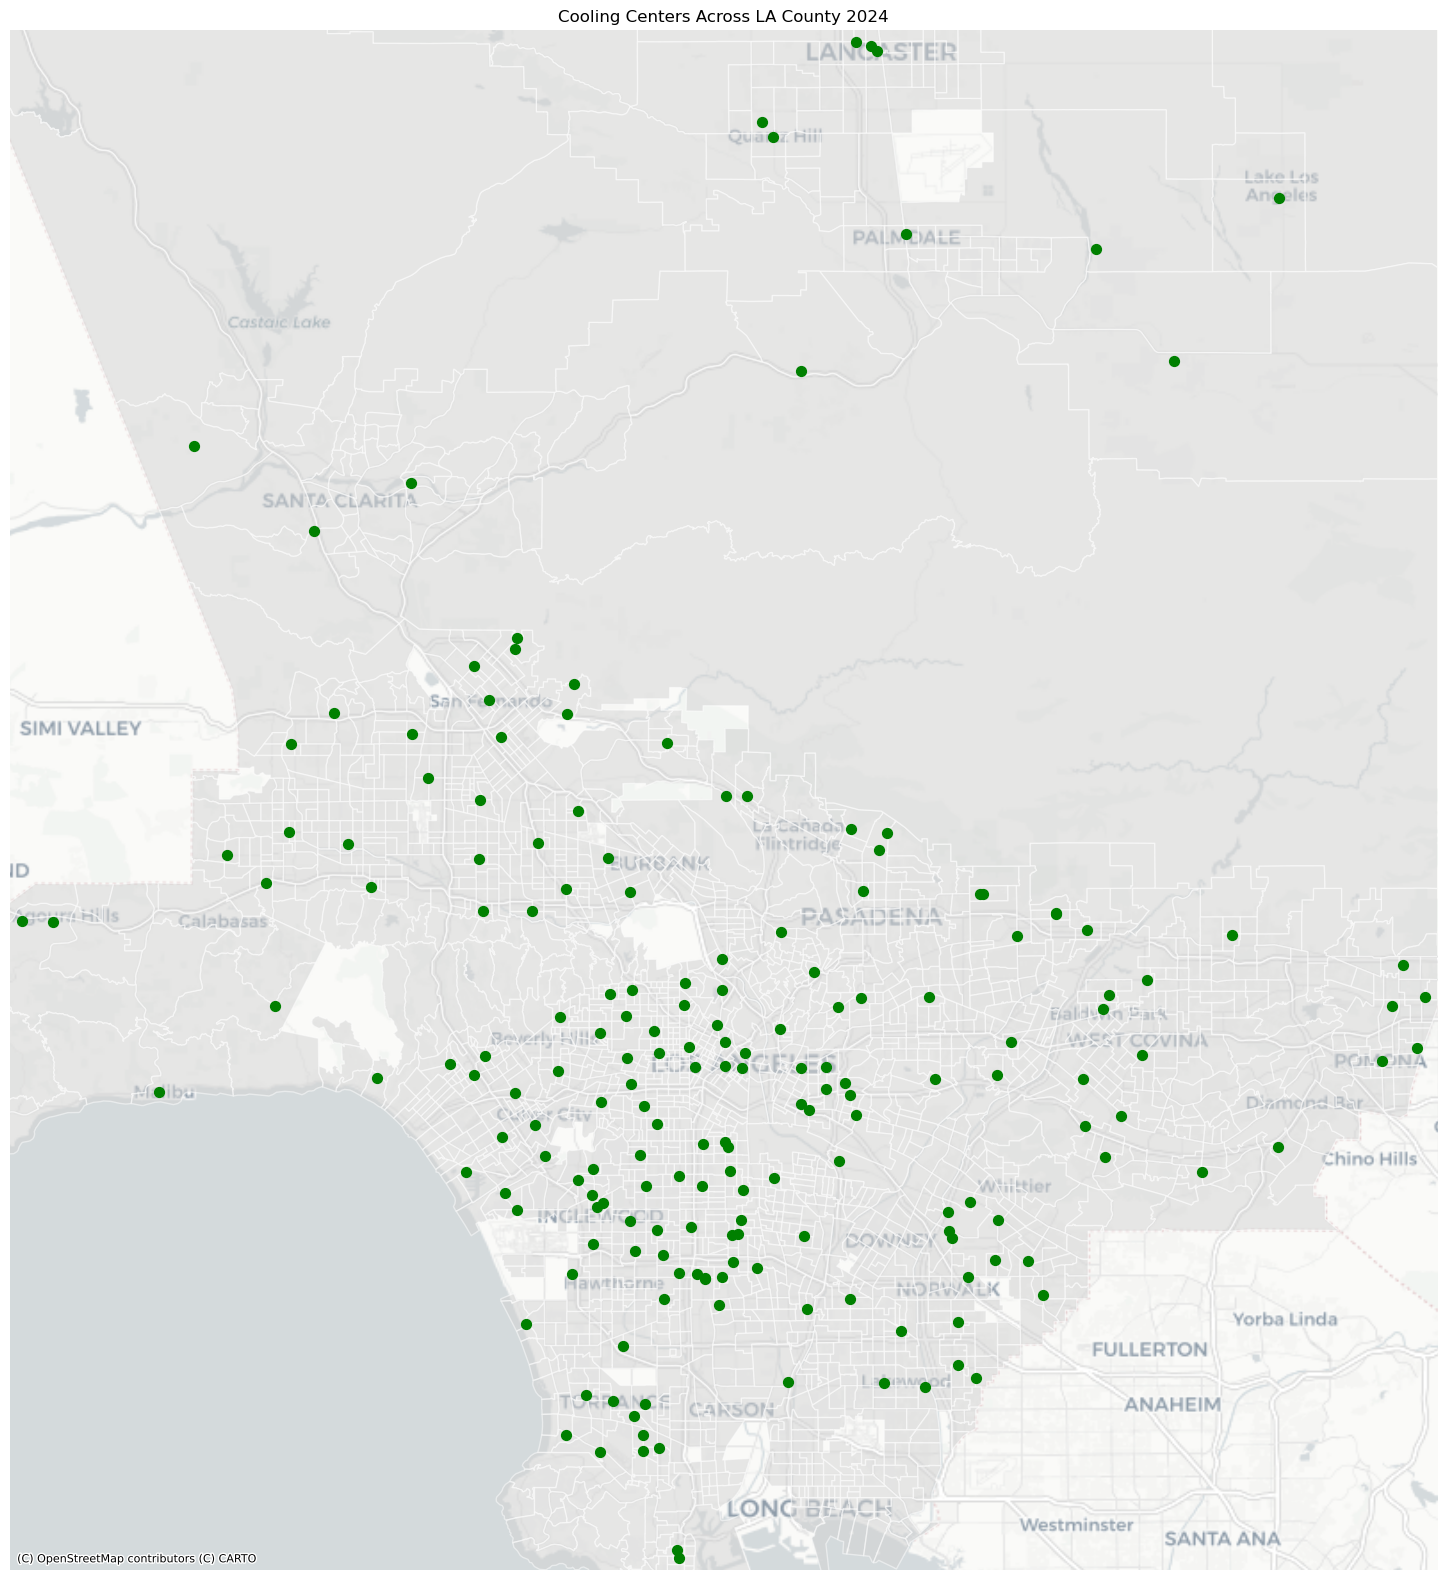

In [38]:
fig, ax = plt.subplots(figsize=(20, 20))

# plot tracts
tracts.plot(ax=ax, # this puts it in the ax plot
        color='lightgray', 
        edgecolor='white',
        alpha=0.5)

# add centers to the plot 
centers.plot(ax=ax, #plot it here in ax in the empty sublot 
        marker='o', #instead of default marker, mark with an o
        markersize=50,
        color='green')

# turn the axes off
ax.axis('off')

ax.set_title('Cooling Centers Across LA County 2024')

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

### Descriptive statistical analysis of centers
- Before merging the dataset,find average number of centers per census tract in LA County
- count the number of centers per tract 

In [39]:
totalTracts = len(tracts.FIPS)
totalCenters = len(centers["name"])

print("There are " + str(totalCenters) + " cooling centers across LA County.")


There are 190 cooling centers across LA County.


In [40]:
totalTracts

2466

In [41]:
#calculate avg population 
TotalPop = sum(tracts.TotalPop)
peoplePerTract = TotalPop / totalTracts
print("There are " + str(round(peoplePerTract)) + " people in a census tract in LA County, on average.")

There are 3992 people in a census tract in LA County, on average.


In [42]:
centerPerTract= totalCenters / totalTracts
centerPerTract

0.0770478507704785

In [43]:
centerPerTractPercent = round(centerPerTract * 100, 2)
print("" + str(centerPerTractPercent) + " of census tracts in LA County have a cooling center.")

7.7 of census tracts in LA County have a cooling center.


### Join tracts with Centers to create one large geopandas df 

In [44]:
#use a left spatial join 
tractsCenters = gpd.sjoin(tracts, centers, how='left')
tractsCenters.columns

Index(['FIPS', 'TotalPop', 'geometry', 'tract code_left', 'centers_count',
       'index_right', 'name', 'address', 'longitude', 'latitude',
       'tract code_right', 'block code', 'street', 'city', 'zip'],
      dtype='object')

In [45]:
# Indices of columns to drop
column_indices_to_drop = [3,4,11]

# Drop columns by index
tractsCenters = tractsCenters.drop(tractsCenters.columns[column_indices_to_drop], axis=1)#

In [46]:
#check projection
print(tractsCenters.crs)
print(centers.crs)
print(tracts.crs)

EPSG:3857
EPSG:3857
EPSG:3857


## Create an index to determine which tracts have to travel the farthest to reach a cooling center. 
We will create an index of tracts within 0.5 miles, 1 mile, 2.5 miles, 5 miles, 10 miles, or more to calculate distance to a cooling center.
We will use the centroid of each tract to calculate distance. Some tracts in LA county are much bigger, so using the centroid averages the distance that a person within a large tract needs to travel to reach a center.

In [47]:
#find the centroid of each tract
tractsCenters['centroid'] = tractsCenters.geometry.centroid.to_crs(epsg=4326)

In [48]:
tractsCenters.geometry = tractsCenters.geometry.to_crs(epsg=4326)

In [51]:
#set the index to 5 
tractsCenters["DistancetoCenter Index"] = 5

In [49]:
tractsCenters

,FIPS,TotalPop,geometry,index_right,name,address,longitude,latitude,tract code_right,street,city,zip,centroid
0,06037101110,4152.0,"MULTIPOLYGON (((-118.30229 34.2587, -118.30091...",17.0,Sunland - Tujunga Branch Library,"7771 Foothill Boulevard, Tujunga, 91042",-118.301705,34.258222,101110,7771 Foothill Boulevard,Tujunga,91042,POINT (-118.29299 34.25947)
1,06037101122,4198.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.29015 34.26772)
2,06037101220,3434.0,"MULTIPOLYGON (((-118.28592 34.25404, -118.2859...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.28163 34.25161)
3,06037101221,3931.0,"MULTIPOLYGON (((-118.29792 34.25597, -118.2969...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.29258 34.25433)
4,06037101222,2572.0,"MULTIPOLYGON (((-118.29434 34.25233, -118.2931...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.28853 34.25135)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,06037980024,205.0,"MULTIPOLYGON (((-118.51849 34.18389, -118.5184...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.48862 34.17668)
2462,06037980025,442.0,"MULTIPOLYGON (((-118.26461 33.84745, -118.2638...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.24442 33.84207)
2463,06037980031,970.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.26283 33.73561)
2464,06037980035,642.0,"MULTIPOLYGON (((-117.998 34.02967, -117.99643 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-117.94338 34.01241)


In [50]:
#create buffer distances
buffer_distances = {
    0: 0.5 * 1609.34,  # 0.5 mi gets index rating 0 
    1: 1 * 1609.34,    # 1 mi gets index rating 1
    2: 2.5 * 1609.34,  # 2.5 mi gets index rating 2
    3: 5 * 1609.34,    # 5 mi gets index rating 3
    4: 10 * 1609.34    # 10 mi gets index rating 4
    #anything that does not fall within these buffer distances gets an index rating of 5
}

In [52]:
tractsCenters.head()

,FIPS,TotalPop,geometry,index_right,name,address,longitude,latitude,tract code_right,street,city,zip,centroid,DistancetoCenter Index
0,06037101110,4152.0,"MULTIPOLYGON (((-118.30229 34.2587, -118.30091...",17.0,Sunland - Tujunga Branch Library,"7771 Foothill Boulevard, Tujunga, 91042",-118.301705,34.258222,101110,7771 Foothill Boulevard,Tujunga,91042,POINT (-118.29299 34.25947),5
1,06037101122,4198.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.29015 34.26772),5
2,06037101220,3434.0,"MULTIPOLYGON (((-118.28592 34.25404, -118.2859...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.28163 34.25161),5
3,06037101221,3931.0,"MULTIPOLYGON (((-118.29792 34.25597, -118.2969...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.29258 34.25433),5
4,06037101222,2572.0,"MULTIPOLYGON (((-118.29434 34.25233, -118.2931...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.28853 34.25135),5


In [53]:
#for each center, look at the geometries within 0.5 miles, 1, 5, 10, 15
for index, buffer_size in buffer_distances.items():
    for point_geom in centers.geometry:
        # Create buffer and convert back to original CRS
        buffer_geom = point_geom.buffer(buffer_size)
        buffer_geom = gpd.GeoSeries(buffer_geom, crs="EPSG:3857").to_crs(epsg=4326).iloc[0]
        
        # Update buffer index only if the tract does not already have a smaller index
        tractsCenters.loc[tractsCenters['centroid'].within(buffer_geom) & (tractsCenters["DistancetoCenter Index"] > index), "DistancetoCenter Index"] = index


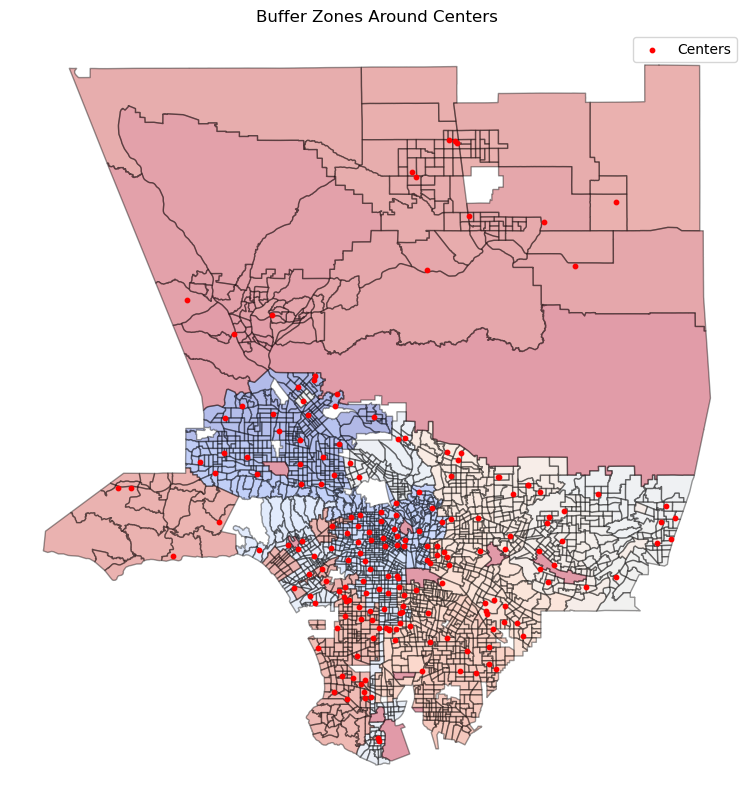

In [57]:
# Assuming `centers` is a GeoDataFrame with points
buffer_gdfs = []

for index, buffer_size in buffer_distances.items():
    buffered = centers.copy()
    buffered["geometry"] = buffered.geometry.buffer(buffer_size)  # Create buffer
    buffered["buffer_size"] = buffer_size  # Store buffer size
    buffer_gdfs.append(buffered)

# Merge all buffers into one GeoDataFrame
buffer_gdf = gpd.GeoDataFrame(pd.concat(buffer_gdfs, ignore_index=True), crs=centers.crs)

# Plot the buffers and centers
fig, ax = plt.subplots(figsize=(10, 10))
tracts.plot(ax=ax, alpha=0.4, cmap="coolwarm", edgecolor="black")  # Buffers
#buffered.plot(ax=ax, alpha=0.4, cmap="cool", edgecolor="black")
centers.plot(ax=ax, color="red", markersize=10, label="Centers")  # Center points
plt.legend()
plt.title("Buffer Zones Around Centers")
ax.axis('off')
plt.show()

Blue areas on the map show higher concentrations of tracts that are within closer distances to centers, whereas tracts shaded red are farther away. 

In [58]:
# Convert back to original CRS (EPSG:4326)
tractsCenters = tractsCenters.to_crs(epsg=4326)

In [59]:
# Save the updated tracts file
#tracts.to_file("tracts_with_buffer_index.shp")

In [60]:
tractsCenters.head()

,FIPS,TotalPop,geometry,index_right,name,address,longitude,latitude,tract code_right,street,city,zip,centroid,DistancetoCenter Index
0,06037101110,4152.0,"MULTIPOLYGON (((-118.30229 34.2587, -118.30091...",17.0,Sunland - Tujunga Branch Library,"7771 Foothill Boulevard, Tujunga, 91042",-118.301705,34.258222,101110,7771 Foothill Boulevard,Tujunga,91042,POINT (-118.29299 34.25947),1
1,06037101122,4198.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.29015 34.26772),2
2,06037101220,3434.0,"MULTIPOLYGON (((-118.28592 34.25404, -118.2859...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.28163 34.25161),2
3,06037101221,3931.0,"MULTIPOLYGON (((-118.29792 34.25597, -118.2969...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.29258 34.25433),1
4,06037101222,2572.0,"MULTIPOLYGON (((-118.29434 34.25233, -118.2931...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-118.28853 34.25135),2


In [61]:
print(tractsCenters["DistancetoCenter Index"].value_counts().sort_index())

DistancetoCenter Index
0     300
1     603
2    1120
3     372
4      74
5       8
Name: count, dtype: int64


In [62]:
tractsCenters.shape

(2477, 14)

There are duplicates since some tracts have more than 1 center. We will delete duplicate and keep only record of the tract , even though the address information for their centers might be different since this is not necessary for the analysis.

In [63]:
duplicates = tractsCenters[tractsCenters.duplicated(subset="FIPS", keep=False)]

In [64]:
duplicates

,FIPS,TotalPop,geometry,index_right,name,address,longitude,latitude,tract code_right,street,city,zip,centroid,DistancetoCenter Index
21,06037104124,4090.0,"MULTIPOLYGON (((-118.3918 34.27762, -118.3916 ...",172.0,Lake View Terrace Branch Library,"12002 Osborne Street, Lake View Terrace, 91342",-118.378246,34.276621,104124,12002 Osborne Street,Lake View Terrace,91342,POINT (-118.37483 34.28728),1
21,06037104124,4090.0,"MULTIPOLYGON (((-118.3918 34.27762, -118.3916 ...",179.0,Dexter Park,"11053 N. Trail Road, Sylmar, 91342",-118.373261,34.295421,104124,11053 N. Trail Road,Sylmar,91342,POINT (-118.37483 34.28728),1
43,06037106111,4707.0,"MULTIPOLYGON (((-118.42134 34.3154, -118.41981...",19.0,El Cariso Community Regional Park,"13100 Hubbard St, Sylmar, 91342",-118.418352,34.317976,106111,13100 Hubbard St,Sylmar,91342,POINT (-118.4099 34.31891),1
43,06037106111,4707.0,"MULTIPOLYGON (((-118.42134 34.3154, -118.41981...",0.0,Veteran's Memorial Community Regional Park,"13000 Sayre St, Sylmar, 91342",-118.417156,34.324843,106111,13000 Sayre St,Sylmar,91342,POINT (-118.4099 34.31891),1
789,06037228710,4104.0,"MULTIPOLYGON (((-118.25648 34.00394, -118.2562...",95.0,Vermont Square Branch Library,"1201 W. 48th. Street, Los Angeles, 90037",-118.254270,33.999892,228710,1201 W. 48th. Street,Los Angeles,90037,POINT (-118.25429 33.99937),0
789,06037228710,4104.0,"MULTIPOLYGON (((-118.25648 34.00394, -118.2562...",77.0,Vernon - Leon H. Washington Jr. Memorial Branc...,"4504 S. Central Avenue, Los Angeles, 90011",-118.256404,34.002799,228710,4504 S. Central Avenue,Los Angeles,90011,POINT (-118.25429 33.99937),0
1085,06037296600,5368.0,"MULTIPOLYGON (((-118.29675 33.73607, -118.2967...",64.0,San Pedro Regional Library,"931 S. Gaffey Street, San Pedro, 90731",-118.292406,33.736381,296600,931 S. Gaffey Street,San Pedro,90731,POINT (-118.29236 33.73978),0
1085,06037296600,5368.0,"MULTIPOLYGON (((-118.29675 33.73607, -118.2967...",56.0,San Pedro Service Center,"769 W. Third Street, San Pedro, 90731",-118.293815,33.741439,296600,769 W. Third Street,San Pedro,90731,POINT (-118.29236 33.73978),0
1389,06037430502,6494.0,"MULTIPOLYGON (((-118.06811 34.16669, -118.0658...",30.0,Sierra Madre Library,"350 W Sierra Madre Blvd, Sierra Madre, 91024",-118.060192,34.161792,430502,350 W Sierra Madre Blvd,Sierra Madre,91024,POINT (-118.0533 34.16192),0
1389,06037430502,6494.0,"MULTIPOLYGON (((-118.06811 34.16669, -118.0658...",163.0,Hart Park House Senior Center,"222 W Sierra Madre Blvd, Sierra Madre, 91024",-118.057534,34.161800,430502,222 W Sierra Madre Blvd,Sierra Madre,91024,POINT (-118.0533 34.16192),0


In [65]:
# Identify rows where the previous row has the same value in the "Category" column
tractsCenters['previous_duplicate'] = tractsCenters['FIPS'].shift(1) == tractsCenters['FIPS']

# Drop rows where the previous row has a duplicate value
tractsCenters = tractsCenters[~tractsCenters['previous_duplicate']]

# Drop the 'previous_duplicate' column
tractsCenters = tractsCenters.drop(columns=['previous_duplicate'])

In [66]:
tractsCenters.shape

(2466, 14)

In [67]:
tractsCenters.columns

Index(['FIPS', 'TotalPop', 'geometry', 'index_right', 'name', 'address',
       'longitude', 'latitude', 'tract code_right', 'street', 'city', 'zip',
       'centroid', 'DistancetoCenter Index'],
      dtype='object')

In [68]:
tractsCenters.to_csv('centers_index.csv', index=False)

### Calculate Population Statistics 

In [69]:
#calculate avg population 
TotalPop = sum(tracts.TotalPop)
totalTracts = len(tracts.FIPS)
peoplePerTract = TotalPop / totalTracts
print(round(peoplePerTract))

3992


Because there are an average of ~4,000 people per census tract, we want to normalize the data by calculating center per 4,000 people.  

### Normalize data

In [70]:
tracts['centers_per_4000'] = tracts['centers_count']/tracts['TotalPop']*1000

In [71]:
tracts.sort_values(by="centers_per_4000").head()

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000
1028,06037275604,10392.0,"MULTIPOLYGON (((-13183554.382 4025066.42, -131...",275604,1.0,0.096228
2275,06037702900,8844.0,"MULTIPOLYGON (((-13187282.249 4026266.782, -13...",702900,1.0,0.113071
1603,06037502303,8229.0,"MULTIPOLYGON (((-13145589.982 4024395.819, -13...",502303,1.0,0.121521
1610,06037502700,7569.0,"MULTIPOLYGON (((-13146058.304 4022177.987, -13...",502700,1.0,0.132118
2396,06037911100,7331.0,"MULTIPOLYGON (((-13149164.563 4109899.923, -13...",911100,1.0,0.136407


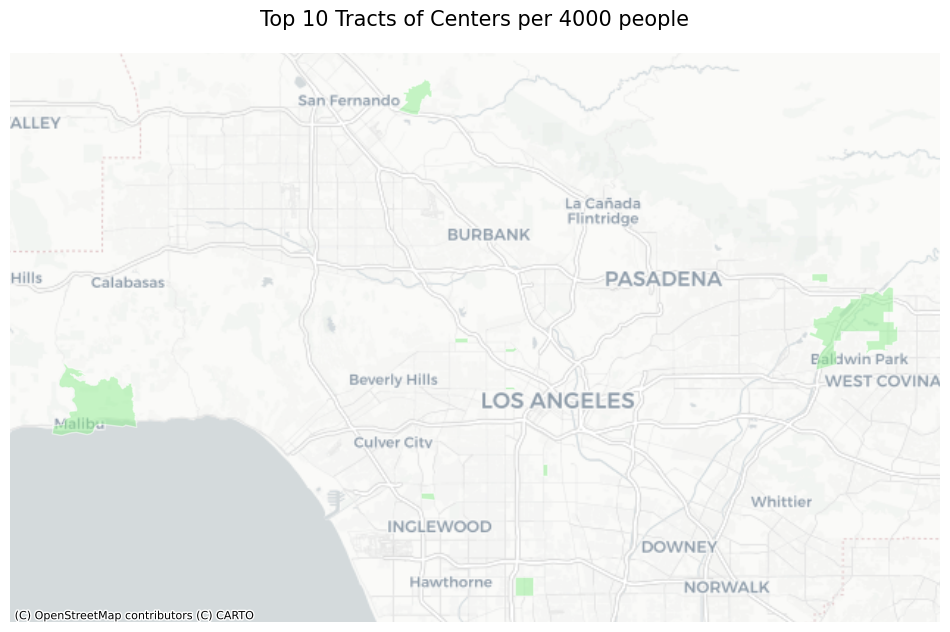

In [72]:
# map the top 10 geographies with centers per 4,000 people 
fig,ax = plt.subplots(figsize=(12,10))
tracts.sort_values(by='centers_per_4000',ascending=False)[:10].plot(ax=ax,
                                                                 color='lightgreen',
                                                                 edgecolor='white',
                                                                 alpha=0.5)
# title
ax.set_title('Top 10 Tracts of Centers per 4000 people',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [73]:
tracts.head()

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000
0,06037101110,4152.0,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",101110,1.0,0.240848
1,06037101122,4198.0,"MULTIPOLYGON (((-13169467.902 4065613.937, -13...",101122,NaN,NaN
2,06037101220,3434.0,"MULTIPOLYGON (((-13167528.828 4062965.287, -13...",101220,NaN,NaN
3,06037101221,3931.0,"MULTIPOLYGON (((-13168864.105 4063224.413, -13...",101221,NaN,NaN
4,06037101222,2572.0,"MULTIPOLYGON (((-13168465.581 4062734.852, -13...",101222,NaN,NaN


In [74]:
#drop null values so we can only focus on census tracts with centers
tractswithCenters = tracts.dropna()

There should only be 179 rows, since there are only 179 census tracts with cooling centers based on the above data 

In [75]:
tractswithCenters

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000
0,06037101110,4152.0,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",101110,1.0,0.240848
21,06037104124,4090.0,"MULTIPOLYGON (((-13179315.447 4066141.344, -13...",104124,2.0,0.488998
30,06037104404,3374.0,"MULTIPOLYGON (((-13184154.06 4064004.388, -131...",104404,1.0,0.296384
43,06037106111,4707.0,"MULTIPOLYGON (((-13182603.157 4071231.574, -13...",106111,2.0,0.424899
53,06037106520,5484.0,"MULTIPOLYGON (((-13188354.923 4070518.351, -13...",106520,1.0,0.182349
...,...,...,...,...,...,...
2395,06037911001,3546.0,"MULTIPOLYGON (((-13139199.242 4096495.376, -13...",911001,1.0,0.282008
2396,06037911100,7331.0,"MULTIPOLYGON (((-13149164.563 4109899.923, -13...",911100,1.0,0.136407
2419,06037920048,5502.0,"MULTIPOLYGON (((-13191875.18 4086032.342, -131...",920048,1.0,0.181752
2424,06037920106,3576.0,"MULTIPOLYGON (((-13216571.854 4092694.054, -13...",920106,1.0,0.279642


### Conduct Global Spatial Autocorrelation 

We will use Global Moran's I statistic to *quantify* the degree to which similar geographies are clustered. We compare each geography based on a given value (in this case centers counts) with that of its neighbors. First, we need to apply a spatial weight. We use the KNN spatial weight, where `k` is the number of "nearest neighbors" to count in the calculations. We decided to use`k=8` for our KNN spatial weights. 

We also **row standardize** the data to adjust the weights in a spatial weights matrix. When weights are row standardized, each weight is divided by its row sum. The row sum is the sum of weights for a features neighbors.

### Apply spatial weight 

In [76]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(tractswithCenters,k=8)

# Row-standardization
wq.transform = 'r'

### Spatial lag

We use our spatial weights to calculate the spatial lag. The spatial lag is a calculated assignment to each geography in your data, which takes into account the data values from others in their  "neighborhood" as defined by the spatial weight. <b> It takes the average of all the neighbors as defined by the spatial weight to come up with a single associated value. </b>

In [77]:
# create a new column for the spatial lag
tractswithCenters['centers_per_4000_lag'] = lps.weights.lag_spatial(wq, tractswithCenters['centers_per_4000']) #arguments are the weights and then the centers

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [78]:
# take a look at some sample rows
tractswithCenters.head(10)[['FIPS','TotalPop','centers_count','centers_per_4000','centers_per_4000_lag']]

,FIPS,TotalPop,centers_count,centers_per_4000,centers_per_4000_lag
0,06037101110,4152.0,1.0,0.240848,0.274232
21,06037104124,4090.0,2.0,0.488998,0.299337
30,06037104404,3374.0,1.0,0.296384,0.298327
43,06037106111,4707.0,2.0,0.424899,0.296520
53,06037106520,5484.0,1.0,0.182349,0.316934
66,06037108102,3477.0,1.0,0.287604,0.236346
92,06037111402,5998.0,1.0,0.166722,0.273455
108,06037113323,3904.0,1.0,0.256148,0.260098
133,06037117303,4162.0,1.0,0.240269,0.272157
160,06037120104,2603.0,1.0,0.384172,0.252791


In [79]:
# create a column that calculates the difference between centers and lag
tractswithCenters['centers_lag_diff'] = tractswithCenters['centers_per_4000'] - tractswithCenters['centers_per_4000_lag']
# output to get the head and tail
tractswithCenters.sort_values(by='centers_lag_diff')

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000,centers_per_4000_lag,centers_lag_diff
1168,06037311700,5852.0,"MULTIPOLYGON (((-13172594.532 4050990.776, -13...",311700,1.0,0.170882,0.384765,-0.213883
2083,06037601302,6513.0,"MULTIPOLYGON (((-13177202.38 4024458.77, -1317...",601302,1.0,0.153539,0.340700,-0.187161
1028,06037275604,10392.0,"MULTIPOLYGON (((-13183554.382 4025066.42, -131...",275604,1.0,0.096228,0.270665,-0.174437
508,06037195100,4976.0,"MULTIPOLYGON (((-13166525.171 4041677.596, -13...",195100,1.0,0.200965,0.363609,-0.162644
604,06037207712,4927.0,"MULTIPOLYGON (((-13164622.721 4034941.281, -13...",207712,1.0,0.202963,0.363243,-0.160280
...,...,...,...,...,...,...,...,...
2082,06037601301,1888.0,"MULTIPOLYGON (((-13176926.085 4026336.456, -13...",601301,1.0,0.529661,0.283279,0.246382
2326,06037900806,4342.0,"MULTIPOLYGON (((-13152186.775 4123624.877, -13...",900806,2.0,0.460617,0.204383,0.256234
466,06037190701,1643.0,"MULTIPOLYGON (((-13173403.269 4042445.202, -13...",190701,1.0,0.608643,0.338700,0.269943
1402,06037431004,3343.0,"MULTIPOLYGON (((-13136302.931 4049135.52, -131...",431004,2.0,0.598265,0.281104,0.317161


In order to better understand the significance of the spatial lag values, consider the following two geographies: the donut and the diamond

In [80]:
# find the donut aka the tract with highest negative difference
donut = tractswithCenters.sort_values(by='centers_lag_diff').head(1)
donut

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000,centers_per_4000_lag,centers_lag_diff
1168,06037311700,5852.0,"MULTIPOLYGON (((-13172594.532 4050990.776, -13...",311700,1.0,0.170882,0.384765,-0.213883


In [81]:
# the FIPS with highest positive difference
diamond = tractswithCenters.sort_values(by='centers_lag_diff').tail(1)
diamond

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000,centers_per_4000_lag,centers_lag_diff
1280,06037404600,1352.0,"MULTIPOLYGON (((-13136517.221 4042985.784, -13...",404600,1.0,0.739645,0.248019,0.491626


The donut is an area with a low assigned value of center count but its surroundings have high values (LH), whereas a diamond is an area with a high value but neighbored by others with low values (HL).

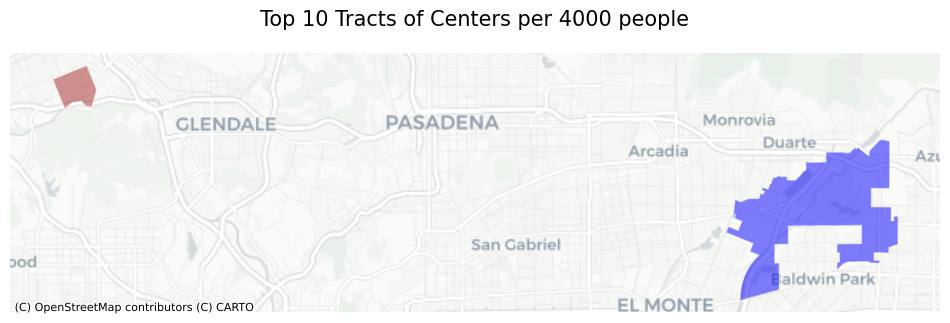

In [82]:
fig,ax = plt.subplots(figsize=(12,10))
donut.plot(ax=ax,
            color='brown',
            edgecolor='white',
            alpha=0.5)

diamond.plot(ax=ax,
            color='blue',
            edgecolor='white',
            alpha=0.5)
# title
ax.set_title('Top 10 Tracts of Centers per 4000 people',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

### Conduct Global Spatial Autocorrelation using Moran's I statistic 

We want to quantify the degree of spatial correlation using Moran's I stat. The moran's I value is the calculated slope of the scatterplot of our "center per 4000" and "centers per 4000 spatial lag" columns. It indicates whether or not we have a positive or negative autocorrelation. 

- **Positive** spatial autocorrelation: high values are close to high values, and/or low values are close to low values
- **Negative** spatial autocorrelation (less common): similar values are far from each other; high values are next to low values, low values are next to high values

In [83]:
y = tractswithCenters.centers_per_4000
moran = Moran(y, wq)
moran.I

np.float64(0.10641033349025616)

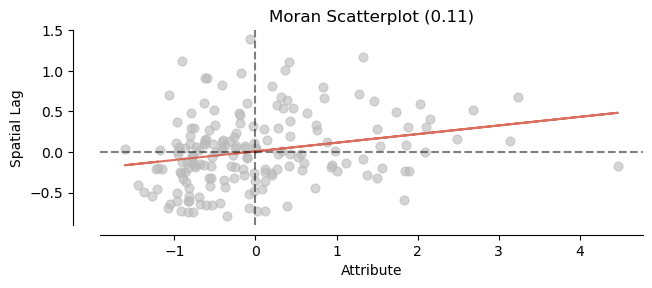

In [84]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

We have a <b> positive spatial </b> autocorrelation, aka neighboring regions tend to have similar values.

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.11', ylabel='Density'>)

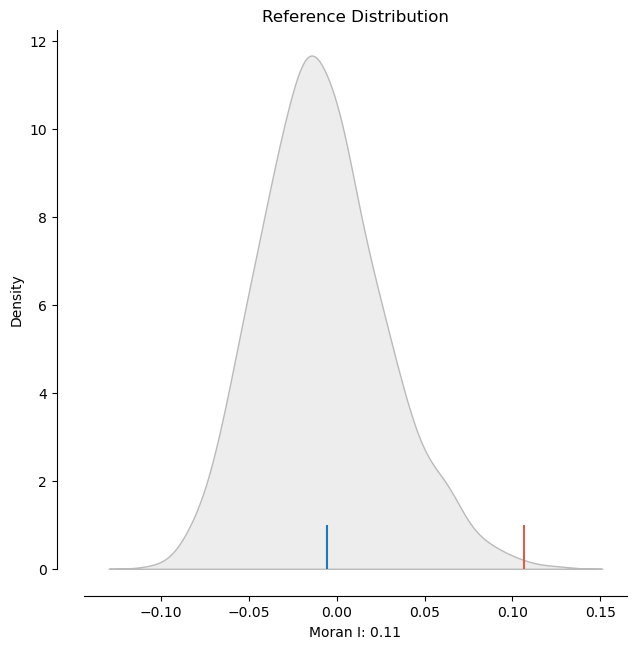

In [85]:
plot_moran_simulation(moran,aspect_equal=False)  

The chart shows that the data are skewed to lower values.

In [86]:
moran.p_sim

np.float64(0.003)

The generated p-value is a very low value, and, by standard terms, it would be deemed statistically significant.  If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran’s I statistic for each of those maps, only 0.6% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.4% of the random maps would receive a smaller (absolute) value of Moran’s I. 

### Conduct Local Spatial Autocorrelation 

We determined there is a positive spatial autocorrelation between the number of centers in census tracts and their locations. But we have not detected where clusters are. We use Local Indicators of Spatial Association (LISA) to classify areas into four groups: high values near to high values (HH), Low values with nearby low values (LL), Low values with high values in its neighborhood, and vice-versa.

- HH: high center count rate geographies near other high center count rate neighbors
- LL: low center count rate geographies near other low  center count neighbors
- LH (donuts): low center count geographies surrounded by high center count neighbors
- HL (diamonds): high center count geographies surrounded by low center count neighbors

In [87]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

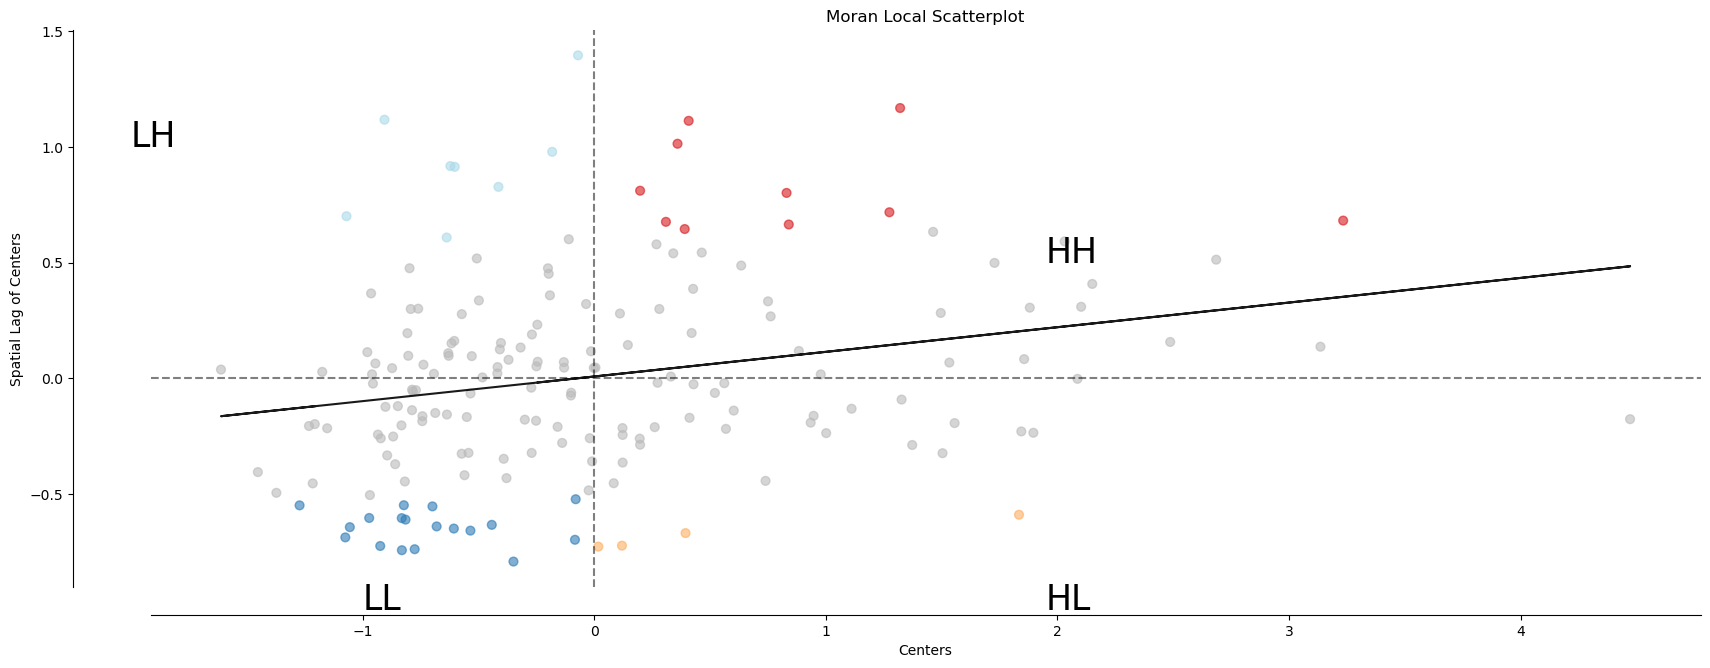

In [88]:
# Plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Centers")
ax.set_ylabel('Spatial Lag of Centers')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

The colored dots in the above scatterpolot represents the census tracts that have a P-value less that 0.05 in each quadrant. In other words, these are the statisticaly significantly, spatially autocorrelated geographies.

### Create a map comparing p-value or different statistically significant areas

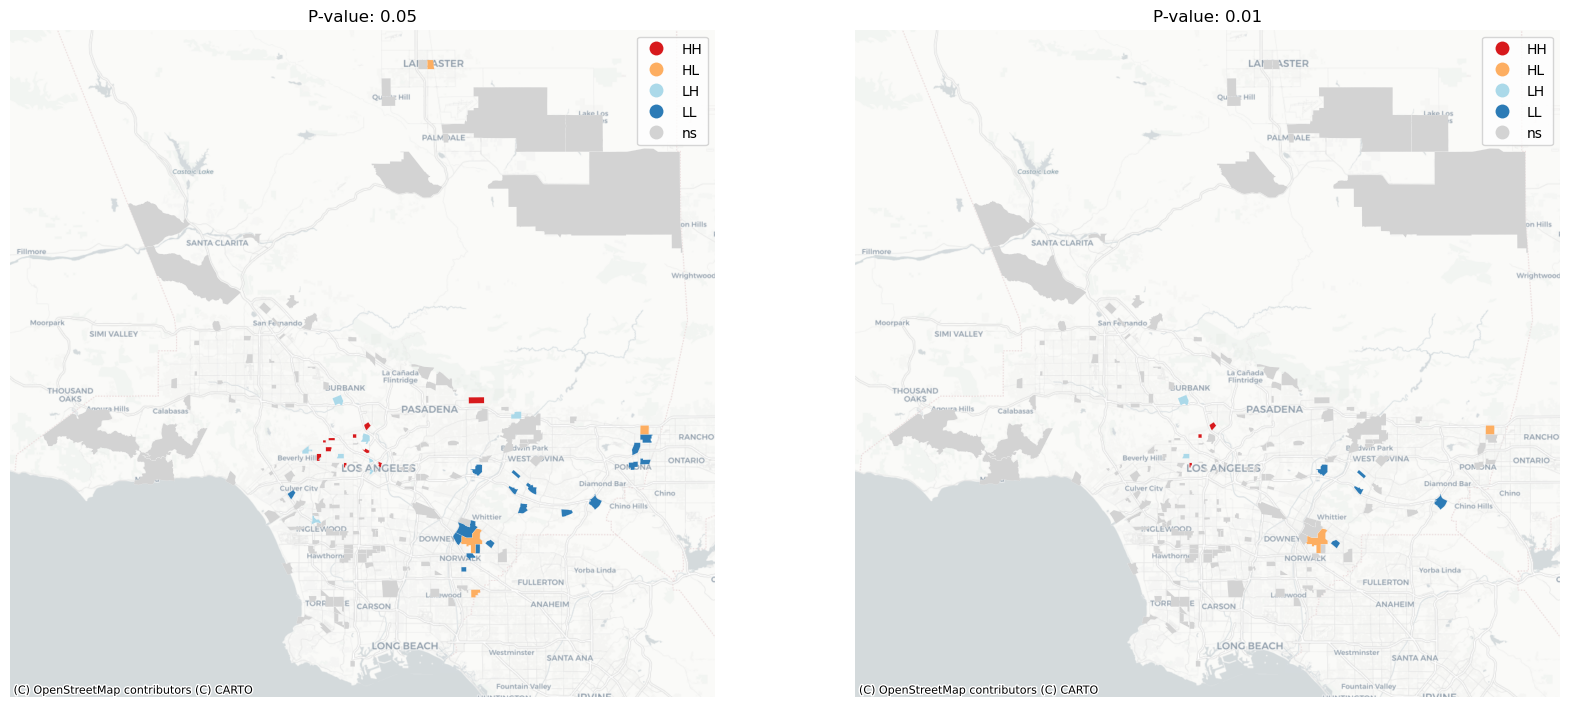

AttributeError: 'numpy.ndarray' object has no attribute 'figure'

In [90]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, tractswithCenters, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, tractswithCenters, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")


# add a basemap
ctx.add_basemap(ax[0],source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax[1],source=ctx.providers.CartoDB.Positron)
plt.show()
ax.figure.savefig('Spatial AutoCorrelation')

Analysis: We see many HH valued tracts clustered in downtown LA, Beverly Hills, and, Hollywood areas which makes sense considering LA city has the highest count of centers in the county. Low center count geographies near other low center count neighbords are sprinkled around Pomona, Downey, and Norwalk. We will want to look at these areas to understand if they have high heat vulnerability, which may expose the need to include more centers in these tracts. 

### Group Contributions: Mia- cleaned datasets. Zix and Cailyn- organized and added analysis write up. Sienna - mapping. We all worked together on global/local spatial autocorrelation